In [26]:
from dataloader import load_balanced_binary_dataset
import backend.src.utils.utils as utils

In [27]:
data = load_balanced_binary_dataset()
data = utils.clean_text(data, "text")

In [28]:
data

,sent_id,text,label
4323,302108-05-02,synes høres naivt gode overvære dj sett alt kl...,1
289,200183-31-01,ønsker velge annet store flertallet klassen st...,1
2909,101115-12-01,vegard forren,1
4336,303721-07-01,resten – synes evnen alminnelige fremstå forbl...,1
4175,703256-12-04,kjæresten irene mareike wang begeistret energi...,1
...,...,...,...
4737,200102-09-02,koster hos expert kjede selger,0
4361,002988-05-04,basstromme klapp dobbeltromme klapp,0
3691,200520-11-03,bilde videkvaliteten ganske midt treet sammenl...,0
1474,201470-15-02,testet tommeren fpw store forventninger storeb...,0


In [29]:
from collections import Counter

num_words = Counter()
for review in data["text"]:
    for word in review.split(" "):
        num_words[word] += 1

num_words = len(num_words)
print("Number of words:", num_words)

Number of words: 12108


<AxesSubplot:>

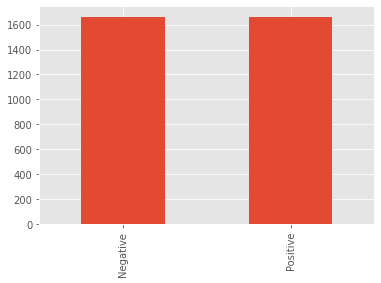

In [30]:
data["label"].replace({0: "Negative", 1: "Positive"}).value_counts().sort_index().plot.bar()

<AxesSubplot:ylabel='Frequency'>

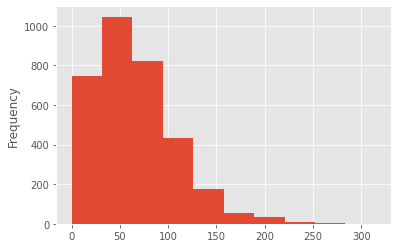

In [31]:
data["text"].str.len().plot.hist()

In [32]:
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from keras_preprocessing.sequence import pad_sequences

X_train, X_test, y_train, y_test = train_test_split(data["text"], data["label"], test_size=0.1, random_state=42, shuffle=True)

tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [33]:
from random import randint

random_idx = randint(0, len(X_train))
review_label_mapping = {0: "Negative", 1: "Positive"}
review_label = review_label_mapping[int(y_train.iloc[random_idx])]

print(f"Review {random_idx} contains {len(X_train[random_idx])} words and is {review_label}")
print("Review content:", end="\n\n")
print(" ".join(tokenizer.index_word[idx] for idx in X_train[random_idx]))

Review 2892 contains 2 words and is Negative
Review content:

barnlig grøsser


In [34]:
word_counter = Counter()
for review in X_train:
    for word in review:
        word_counter[tokenizer.index_word[word]] += 1

In [35]:
word_counter.most_common(10)

[('litt', 152),
 ('gjør', 97),
 ('filmen', 96),
 ('the', 93),
 ('får', 89),
 ('godt', 86),
 ('nok', 80),
 ('helt', 77),
 ('to', 76),
 ('første', 68)]

In [36]:
maxlen = 100

X_train = pad_sequences(X_train, maxlen=maxlen)
X_test = pad_sequences(X_test, maxlen=maxlen)

In [37]:
import numpy as np

y_train = np.array(y_train)
y_test = np.array(y_test)

In [38]:
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)

X_train shape: (2993, 100)
X_test shape: (333, 100)


In [39]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding

model = Sequential()
model.add(Embedding(input_dim=num_words, output_dim=128))
model.add(LSTM(units=128, dropout=0.4, return_sequences=True))
model.add(LSTM(units=128, dropout=0.4))
model.add(Dense(units=1, activation='sigmoid'))

In [40]:
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 128)         1549824   
                                                                 
 lstm_2 (LSTM)               (None, None, 128)         131584    
                                                                 
 lstm_3 (LSTM)               (None, 128)               131584    
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,813,121
Trainable params: 1,813,121
Non-trainable params: 0
_________________________________________________________________


In [41]:
from keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor="val_accuracy", mode="max", patience=3)

epochs = 20
batch_size = 16
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=1,
                    callbacks=[early_stop])

Epoch 1/20
150/150 [==============================] - 72s 339ms/step - loss: 0.6896 - accuracy: 0.5213 - val_loss: 0.6595 - val_accuracy: 0.6010
Epoch 2/20
150/150 [==============================] - 40s 265ms/step - loss: 0.4204 - accuracy: 0.8112 - val_loss: 0.6981 - val_accuracy: 0.6561
Epoch 3/20
150/150 [==============================] - 44s 296ms/step - loss: 0.1150 - accuracy: 0.9532 - val_loss: 1.0638 - val_accuracy: 0.6544
Epoch 4/20
150/150 [==============================] - 44s 295ms/step - loss: 0.0301 - accuracy: 0.9887 - val_loss: 1.1321 - val_accuracy: 0.6411
Epoch 5/20
150/150 [==============================] - 30s 201ms/step - loss: 0.0242 - accuracy: 0.9929 - val_loss: 1.2481 - val_accuracy: 0.6644
Epoch 6/20
150/150 [==============================] - 30s 199ms/step - loss: 0.0081 - accuracy: 0.9979 - val_loss: 1.5595 - val_accuracy: 0.6594
Epoch 7/20
150/150 [==============================] - 31s 207ms/step - loss: 0.0042 - accuracy: 0.9987 - val_loss: 1.7114 - val_ac

In [42]:
from datetime import datetime

model.save(f"models/SA-LSTM-BINARY-BALANCED-{datetime.now().strftime('%Y%m%d%H%M%S')}.h5")

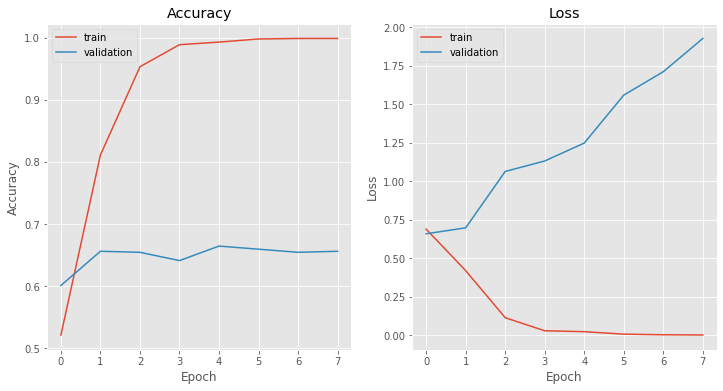

In [43]:
from backend.src.utils.utils import plot_history

plot_history(history)

In [44]:
# Evaluation
val_loss, val_acc = model.evaluate(X_test, y_test)
print("Validation loss:", val_loss)
print("Validation accuracy:", val_acc)

11/11 [==============================] - 1s 96ms/step - loss: 2.3420 - accuracy: 0.5736
Validation loss: 2.341965675354004
Validation accuracy: 0.5735735893249512
